# <font color='#A533FF'>Module 1: Business Understanding</font>

AirBnB is an online-platform dedicated to the offer of accommodation to individuals and tourists (vacation rentals) through which hosts can advertise and contract the rental of their properties with their guests. For this project we will explore and analyze the AirBnB data of Valencia (Spain), a city on the shores of the Mediterranean Sea.


#### Project Structure:

The project follow the CRISP-DM Process (Cross Industry Process for Data Mining):

1. Business Understanding.
2. Data Understanding.
3. Data Preparation.
4. Data Modelling.
5. Result Evaluation.
6. Deployment (available on GitHub repository and Medium Blog Post only).



#### Questions to be answered:



- A. What are the busiest times of the year to visit Valencia? By how much do prices spike?

- B. What type of airbnb is the most booked in the city?

- C. How well can we predict the Valencia Airbnb price? What aspects correlate well to the price?

# <font color='#A533FF'>Module 2: Data Understanding</font>

I choose the following datasets, available on http://insideairbnb.com/get-the-data/, to answer the above questions:

- **calendar.csv:** Contains the availability information, prices and minimum/maximum nights of each rental in Valencia between the period of time 2021-06-27 and 2022-06-28.


- **listings.csv:** Contains detailed information about the rooms/houses, the hosts and the rental neighbourhood. During the project, the information of each variable used will be detailed.

### Importing libraries and loading the data

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import folium.plugins as plugins
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import warnings
warnings.filterwarnings('ignore')

In [164]:
calendar = pd.read_csv("data/calendar_2021.csv")
listings = pd.read_csv("data/listings.csv")

### Exploring the 'calendar' dataset 

In [165]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,193326,2021-06-28,t,$45.00,$45.00,1.0,1125.0
1,48154,2021-06-28,f,$45.00,$45.00,3.0,25.0
2,48154,2021-06-29,f,$45.00,$45.00,3.0,25.0
3,48154,2021-06-30,f,$45.00,$45.00,3.0,25.0
4,48154,2021-07-01,f,$45.00,$45.00,3.0,25.0


In [166]:
print("The calendar dataset has " + str(calendar.shape[0]) + " rows and " + str(calendar.shape[1]) + " columns.")

The calendar dataset has 1981222 rows and 7 columns.


In [167]:
# Searching all the columns without missing values
no_nulls_calendar = set([calendar.columns[i] for i in range(0,7) if (calendar[(calendar.columns[i])].isna().sum() == 0)])
print(no_nulls_calendar)

{'available', 'date', 'listing_id'}


In [168]:
# Finding columns with more than 50% of their values missing
missing_cols_75_calendar = set(calendar.columns[calendar.isnull().mean() > 0.5])
print(missing_cols_75_calendar)

set()


In [169]:
# Finding columns with more than 2% of their values missing
calendar.columns[calendar.isnull().mean() > 0.02]

Index([], dtype='object')

It is shown that the **% of NaN values is less than 2%** of the total data available, so I proceed to drop the NaN values of this dataset (drop only the rows that contain NaN values for this columns).

In [170]:
calendar_copy = calendar.copy()
calendar_copy = calendar_copy.dropna()
print("The new dataframe has " + str(calendar.shape[0]) + " rows and " + str(calendar.shape[1]) + " columns.")

The new dataframe has 1981222 rows and 7 columns.


In [171]:
calendar_copy.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

We observe that 'price' and 'adjusted_price' variables are shown as type object. It is needed to transform them to numeric as well as remove the dollar symbol in order to achieve it. We will see this later.

In [172]:
# Let's take a look at the summary statistics associated with the quantitative variables
calendar_copy.describe()

,listing_id,minimum_nights,maximum_nights
count,1.980083e+06,1.980083e+06,1.980083e+06
mean,2.947914e+07,5.461517e+00,8.605985e+02
std,1.443045e+07,1.708751e+01,4.628517e+02
min,4.815400e+04,1.000000e+00,1.000000e+00
25%,1.813103e+07,2.000000e+00,3.650000e+02
50%,2.989972e+07,2.000000e+00,1.125000e+03
75%,4.267263e+07,4.000000e+00,1.125000e+03
max,5.064875e+07,3.650000e+02,1.000000e+04


We can extract from this table that 5,45 nights are the mean of minimum nights and 8,6 the maximum nights available in this dataset for this population.

In [173]:
# Knowing the data period of time:
print("Dates are between " + min(calendar_copy["date"]) + " and " + max(calendar_copy["date"]) + ".")

Dates are between 2021-06-27 and 2022-06-28.


### Exploring the 'listings' dataset 

In [174]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,48154,https://www.airbnb.com/rooms/48154,20211218004345,2021-12-18,beautiful apartment wifi,<b>The space</b><br />Hello everybody and than...,NaN,https://a0.muscache.com/pictures/1109085/9c0d4...,219476,https://www.airbnb.com/users/show/219476,Toni,2010-09-01,"Valencia, Valencian Community, Spain",Un saludo a todos. Espero que os pongáis en co...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/219476/profil...,https://a0.muscache.com/im/users/219476/profil...,NaN,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,MORVEDRE,LA SAIDIA,39.48375,-0.37502,Entire rental unit,Entire home/apt,4,NaN,...,$98.00,3,25,3,3,25,25,3.0,25.0,NaN,t,17,47,77,352,2021-12-18,115,16,0,2010-10-12,2021-11-14,4.57,4.66,4.61,4.83,4.72,4.44,4.52,VT-41540-V,f,2,2,0,0,0.84
1,55692,https://www.airbnb.com/rooms/55692,20211218004345,2021-12-18,Delight in city center,A great place to stay and visit Valencia.<br /...,NaN,https://a0.muscache.com/pictures/329316/a5d6a7...,120649,https://www.airbnb.com/users/show/120649,Pilar,2010-05-08,"Valencia, Valencian Community, Spain","We are a couple from Spain, no kids, no pets, ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/120649/profil...,https://a0.muscache.com/im/users/120649/profil...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,LA SEU,CIUTAT VELLA,39.47658,-0.37654,Entire rental unit,Entire home/apt,3,NaN,...,$100.00,1,730,1,1,730,730,1.0,730.0,NaN,t,0,0,0,170,2021-12-18,1,0,0,2014-11-11,2014-11-11,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,1,0,0,0.01
2,95393,https://www.airbnb.com/rooms/95393,20211218004345,2021-12-18,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,"This is ""Edificio Palomar Apartments"", I will ...",It is just 10 min walking distance to the Cath...,https://a0.muscache.com/pictures/931683/64aebc...,508042,https://www.airbnb.com/users/show/508042,Carmen,2011-04-14,"Valencia, Valencian Community, Spain",Nice to meet you. I´m valencian and love my jo...,within a day,89%,36%,f,https://a0.muscache.com/im/pictures/user/ba968...,https://a0.muscache.com/im/pictures/user/ba968...,Ciutat Vella,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Valencia, Valenciana, Spain",EL CARME,CIUTAT VELLA,39.47685,-0.38181,Entire rental unit,Entire home/apt,6,NaN,...,$141.00,2,1125,2,2,1125,1125,2.0,1125.0,NaN,t,13,41,59,200,2021-12-18,103,5,0,2011-06-14,2021-11-14,4.76,4.73,4.89,4.85,4.75,4.75,4.67,31815,f,6,6,0,0,0.80
3,100347,https://www.airbnb.com/rooms/100347,20211218004345,2021-12-18,3BDR full Home at Sorolla station and Metro Jesús,Te va a encantar mi espacio por la ubicación y...,"Barrio de Jesús, cercano al centro, zona conso...",https://a0.muscache.com/pictures/b0bb18e8-1f2

In [175]:
print("The listings dataset has " + str(listings.shape[0]) + " rows and " + str(listings.shape[1]) + " columns.")

The listings dataset has 5546 rows and 74 columns.


In [176]:
# Searching all the columns without missing values
no_nulls_listings = set([listings.columns[i] for i in range(0,74) if (listings[(listings.columns[i])].isna().sum() == 0)])
print(no_nulls_listings)

{'host_id', 'neighbourhood_cleansed', 'maximum_nights', 'availability_60', 'calculated_host_listings_count', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_minimum_nights', 'availability_90', 'maximum_minimum_nights', 'number_of_reviews_ltm', 'availability_30', 'calculated_host_listings_count_private_rooms', 'calendar_last_scraped', 'number_of_reviews', 'scrape_id', 'number_of_reviews_l30d', 'longitude', 'property_type', 'has_availability', 'picture_url', 'instant_bookable', 'name', 'minimum_nights', 'last_scraped', 'calculated_host_listings_count_shared_rooms', 'price', 'host_verifications', 'neighbourhood_group_cleansed', 'host_url', 'latitude', 'minimum_nights_avg_ntm', 'amenities', 'listing_url', 'availability_365', 'accommodates', 'room_type', 'calculated_host_listings_count_entire_homes', 'maximum_nights_avg_ntm', 'id'}


In [177]:
print("The listings dataset has " + str(len(no_nulls_listings)) + " columns without missing values.")

The listings dataset has 40 columns without missing values.


In [178]:
# Finding columns with more than 50% of their values missing
missing_cols_75_listings = set(listings.columns[listings.isnull().mean() > 0.50])
print(missing_cols_75_listings)

{'license', 'calendar_updated', 'host_neighbourhood', 'bathrooms'}


In [179]:
# Finding columns with more than 95% of their values missing
missing_cols_90 = listings.columns[listings.isnull().mean() > 0.95]
print(missing_cols_90)

Index(['bathrooms', 'calendar_updated'], dtype='object')


The *'bathroom'* and *'calendar_updated'* variables have more than 95% of missing values. It is observed that the *'bathrooms_text'* variable contains the number of bathrooms available in the houses, so I decided to drop it from the dataset. Furthermore, the *'calendar_updated'* column has no values (100% of missing data) so I will also drop it.

On the other hand, the *'license'* and *'host_neighbourhood'* column have more than 50% of missing values. I decided to drop *'license'* from this project and *'host_neighbourhood'* because the *'neighbourhood_group_cleansed'* variable gives me the information that is missing on it.

In [180]:
listings_copy = listings.copy()
listings_copy = listings_copy.drop(columns=['bathrooms', 'calendar_updated', 'license', 'host_neighbourhood'])
print("The new dataframe has " + str(listings_copy.shape[0]) + " rows and " + str(listings_copy.shape[1]) + " columns.")

The new dataframe has 5546 rows and 70 columns.


In [181]:
listings_copy.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5.546000e+03,5.546000e+03,5.546000e+03,5545.000000,5545.000000,5546.000000,5546.000000,5546.000000,5252.000000,5429.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,5546.000000,4819.000000,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000,5546.000000,5546.000000,5546.000000,5546.000000,4819.000000
mean,3.203663e+07,2.021122e+13,1.444750e+08,16.371867,16.371867,39.467737,-0.364004,3.646953,1.791698,2.433782,6.175081,715.492968,6.354670,7.765417,851.737649,869.729715,7.050811,865.370754,11.795709,28.554454,46.123152,175.007212,41.281825,8.831951,0.808871,4.586510,4.711162,4.613207,4.790532,4.776192,4.711890,4.573605,9.388749,7.994410,1.360079,0.010458,1.373077
std,1.568328e+07,1.937675e+00,1.307299e+08,136.443721,136.443721,0.022815,0.023157,2.033743,0.994377,1.669520,27.997684,509.059083,27.576899,28.750893,460.993309,450.395077,28.243888,451.091347,10.645713,22.286511,33.390049,128.447881,65.298773,12.207474,1.457384,0.574609,0.428752,0.486661,0.403178,0.405643,0.379884,0.469426,23.598115,23.285203,3.343457,0.175811,1.333834
min,4.815400e+04,2.021122e+13,5.947000e+03,0.000000,0.000000,39.279330,-0.427840,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.918170e+07,2.021122e+13,3.253363e+07,1.000000,1.000000,39.462950,-0.379647,2.000000,1.000000,1.000000,1.000000,90.000000,2.000000,2.000000,365.000000,365.000000,2.000000,365.000000,0.000000,2.000000,9.000000,58.000000,3.000000,0.000000,0.000000,4.500000,4.640000,4.500000,4.770000,4.740000,4.600000,4.470000,1.000000,0.000000,0.000000,0.000000,0.370000
50%,3.295835e+07,2.021122e+13,1.028993e+08,2.000000,2.000000,39.470020,-0.371835,4.000000,1.000000,2.000000,2.000000,1125.000000,2.000000,3.000000,1125.000000,1125.000000,2.000000,1125.000000,11.000000,31.000000,52.000000,168.000000,13.000000,4.000000,0.000000,4.720000,4.830000,4.750000,4.900000,4.900000,4.810000,4.680000,2.000000,1.000000,0.000000,0.000000,0.980000
75%,4.663667e+07,2.021122e+13,2.260539e+08,6.000000,6.000000,39.475700,-0.345225,5.000000,2.000000,3.000000,3.000000,1125.000000,3.000000,5.000000,1125.000000,1125.000000,4.000000,1125.000000,21.000000,49.000000,77.000000,304.000000,51.000000,13.000000,1.000000,4.890000,4.940000,4.920000,5.000000,5.000000,4.960000,4.830000,6.000000,4.000000,1.000000,0.000000,2.000000
max,5.387368e+07,2.021122e+13,4.362986e+08,3750.000000,3750.000000,39.562660,-0.276100,16.000000,10.000000,22.000000,1000.000000,10000.000000,1000.000000,1000.000000,10000.000000,10000.000000,1000.000000,10000.000000,30.000000,60.000000,90.000000,365.000000,678.000000,164.000000,16.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,140.000000,137.000000,28.000000,5.000000,13.040000


We can observe that 1 and 10 are the minimum and maximum of bedrooms in all the rents of the dataset. We can also extract that all the review scores are in the range 1-5.

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>],
       [<AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_60'}>]], dtype=object)

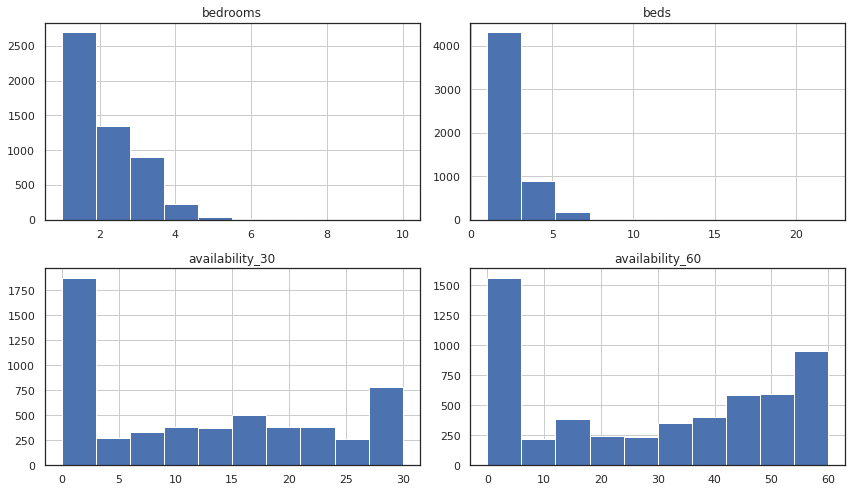

In [182]:
# Constructing some histograms to visualize the distrubution of the variables below
listings_copy[['bedrooms', 'beds', 'availability_30', 'availability_60']].hist()

We see that rentals with 1 bedrooms or having 1 bed are the most common in the Valencia dataset.

In [183]:
# Extracting what type of neighbourhoods are in the city and its count
neighbourhood_counts = listings_copy["neighbourhood_group_cleansed"].value_counts().reset_index()

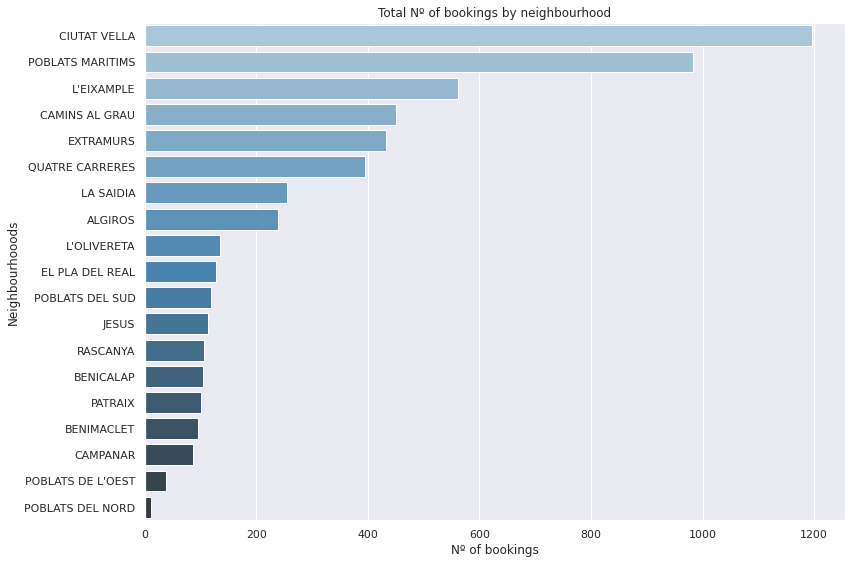

In [184]:
# Representing the total of bookings per neighbourhood
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.barplot(x= "neighbourhood_group_cleansed", y = "index", data = neighbourhood_counts, palette="Blues_d").set(title='Total Nº of bookings by neighbourhood')
plt.xlabel('Nº of bookings')
plt.ylabel('Neighbourhooods')
plt.show()

Ciutat Vella and Poblats Marítims are the most requested neighbourhoods by the users for this period of time. Moreover, Ciutat Vella has the double of bookings than the other 17 neighbourhoods. Later, this information will be displayed with the coordinates.

Finally, I represented all the rentals in the city for our period of time with the coordinates ('latitude' and 'longitude' variables in the listings dataset). This give us an idea of where they are located on the map.

In [185]:
valencia_locations = list(zip(listings_copy['latitude'], listings_copy['longitude']))

# I centered the map using the coordinates of Valencia
map1 = folium.Map(location = [39.4702, -0.376805], zoom_start = 13)
plugins.FastMarkerCluster(data = valencia_locations).add_to(map1)
map1

# <font color='#A533FF'>Module 3: Data Preparation</font>

### 1. What are the busiest times of the year to rent a room in Valencia? By how much do prices spike?

In order to answer this question, it is needed to extract all the available rents during our data period of time.

To represent availability through time we need the 'available' column of the calendar dataset that is True ('t') and then, plot it with the dates.

Text(0, 0.5, 'Availability rate')

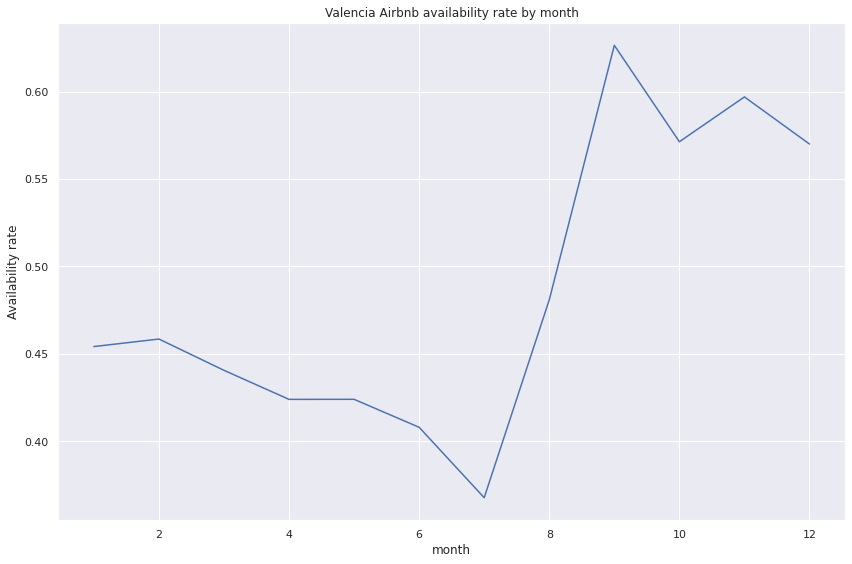

In [186]:
# Selecting only the rows with availability -> True
calendar_copy['available'] = calendar_copy['available'] == 't'

# Extracting the month of the 'date' column
calendar_copy['month'] = pd.DatetimeIndex(calendar_copy['date']).month
ax = calendar_copy.groupby('month')['available'].mean().plot(title = 'Valencia Airbnb availability rate by month')
ax.set_ylabel("Availability rate")

Taking into account that the time period of our data is from 2021-06-27 and 2022-06-28, we observe that the most requested period to book a rental is on July. Also the period between March-June, due to many events that take place in the city (Fallas, Easter season and the beggining of the summer).

It is important taking into account that the extraction of this data was made on 2021-12-18.

Text(0, 0.5, 'Price')

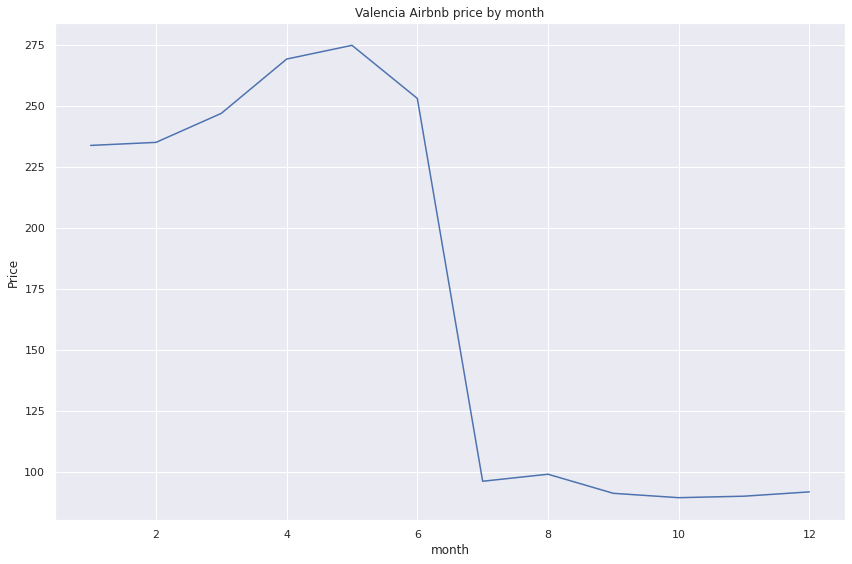

In [187]:
calendar_copy['price'] = calendar_copy['price'].replace('[\$,]', '', regex=True).astype(float)
calendar_copy['month'] = pd.DatetimeIndex(calendar_copy['date']).month

ax = calendar_copy.groupby('month')['price'].mean().plot(title='Valencia Airbnb price by month')
ax.set_ylabel("Price")

In that period of time, we observe that the price raises on March-June (it could be due to the Fallas, the Easter and the beggining of the summer period) between 250-275 €/nigth. Conversely, the lowest prices per night for this dataset are all around 100€ during the summer (July-September) and winter seasons. We observe before that the availability on July is very low, so this will be explained due to the rental price (the lowest).

### 2.  What type of airbnb is the most booked in the city?

In [188]:
# Types of properties and its counts
listings.property_type.value_counts()

Entire rental unit                     2973
Private room in rental unit            1228
Entire loft                             389
Entire condominium (condo)              137
Entire serviced apartment               127
Entire residential home                 108
Private room in residential home        106
Private room in condominium (condo)      71
Private room in bed and breakfast        58
Private room in casa particular          42
Room in boutique hotel                   38
Private room in serviced apartment       36
Entire townhouse                         35
Room in hotel                            31
Private room in hostel                   29
Private room in guest suite              12
Private room in loft                     11
Entire guest suite                        9
Entire vacation home                      8
Shared room in rental unit                8
Entire place                              8
Private room in townhouse                 8
Boat                            

The most frequent property type is an entire rental unit, privates rooms in rental units, entire lofts and also an entire serviced apartment. The less frequent type are shared rooms in farm stays and entire cottages, for example.

Next, it is needed to explore the 'room_type' variable that give us the information about the rental type (house, single room, apartment...).

In [189]:
listings_copy.room_type.value_counts()

Entire home/apt    3829
Private room       1672
Hotel room           24
Shared room          21
Name: room_type, dtype: int64

The most frequent rental type by difference is entire homes or apartments. The less frequent are the shared rooms.

In [190]:
# Merge by 'id' column
calendar_listings = pd.merge(calendar_copy, listings_copy, left_on='listing_id', right_on='id')
calendar_listings.shape

(1521471, 78)

In [191]:
calendar_listings.head()

,listing_id,date,available,price_x,adjusted_price,minimum_nights_x,maximum_nights_x,month,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,...,beds,amenities,price_y,minimum_nights_y,maximum_nights_y,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,193326,2021-06-28,True,45.0,$45.00,1.0,1125.0,6,193326,https://www.airbnb.com/rooms/193326,20211218004345,2021-12-18,"Sunny balcony room, beach & city",<b>The space</b><br />Room with its own sunny ...,NaN,https://a0.muscache.com/pictures/2038147/98b40...,937597,https://www.airbnb.com/users/show/937597,Noelia,2011-08-07,"Valencia, Valencian Community, Spain",Me considero afortunada de haber nacido en est...,within a few hours,90%,98%,t,https://a0.muscache.com/im/users/937597/profil...,https://a0.muscache.com/im/users/937597/profil...,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,CABANYAL-CANYAMELAR,...,2.0,"[""Lock on bedroom door"", ""Cleaning products"", ...",$50.00,1,1125,1,1,1125,1125,1.0,1125.0,t,30,60,90,257,2021-12-18,193,16,0,2011-10-24,2021-11-14,4.84,4.87,4.87,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
1,193326,2021-06-29,True,45.0,$45.00,1.0,1125.0,6,193326,https://www.airbnb.com/rooms/193326,20211218004345,2021-12-18,"Sunny balcony room, beach & city",<b>The space</b><br />Room with its own sunny ...,NaN,https://a0.muscache.com/pictures/2038147/98b40...,937597,https://www.airbnb.com/users/show/937597,Noelia,2011-08-07,"Valencia, Valencian Community, Spain",Me considero afortunada de haber nacido en est...,within a few hours,90%,98%,t,https://a0.muscache.com/im/users/937597/profil...,https://a0.muscache.com/im/users/937597/profil...,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,CABANYAL-CANYAMELAR,...,2.0,"[""Lock on bedroom door"", ""Cleaning products"", ...",$50.00,1,1125,1,1,1125,1125,1.0,1125.0,t,30,60,90,257,2021-12-18,193,16,0,2011-10-24,2021-11-14,4.84,4.87,4.87,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
2,193326,2021-06-30,True,45.0,$45.00,1.0,1125.0,6,193326,https://www.airbnb.com/rooms/193326,20211218004345,2021-12-18,"Sunny balcony room, beach & city",<b>The space</b><br />Room with its own sunny ...,NaN,https://a0.muscache.com/pictures/2038147/98b40...,937597,https://www.airbnb.com/users/show/937597,Noelia,2011-08-07,"Valencia, Valencian Community, Spain",Me considero afortunada de haber nacido en est...,within a few hours,90%,98%,t,https://a0.muscache.com/im/users/937597/profil...,https://a0.muscache.com/im/users/937597/profil...,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,CABANYAL-CANYAMELAR,...,2.0,"[""Lock on bedroom door"", ""Cleaning products"", ...",$50.00,1,1125,1,1,1125,1125,1.0,1125.0,t,30,60,90,257,2021-12-18,193,16,0,2011-10-24,2021-11-14,4.84,4.87,4.87,4.91,4.94,4.74,4.82,f,2,0,2,0,1.56
3,193326,2021-07-01,True,45.0,$45.00,1.0,1125.0,7,193326,https://www.airbnb.com/rooms/193326,20211218004345,2021-12-18,"Sunny balcony room, beach & city",<b>The space</b><br />Room with its own sunny ...,NaN,https://a0.muscach

In [192]:
available_roomtype = calendar_listings.groupby(['available','room_type']).size().reset_index(name='Count')
available_roomtype

,available,room_type,Count
0,False,Entire home/apt,603742
1,False,Hotel room,5315
2,False,Private room,188949
3,False,Shared room,1109
4,True,Entire home/apt,498536
5,True,Hotel room,3080
6,True,Private room,217469
7,True,Shared room,3271


In [193]:
available_roomtype['Percentage'] = [(100 * x/available_roomtype['Count'].sum()).round(2) for x in available_roomtype['Count']]
available_roomtype

,available,room_type,Count,Percentage
0,False,Entire home/apt,603742,39.68
1,False,Hotel room,5315,0.35
2,False,Private room,188949,12.42
3,False,Shared room,1109,0.07
4,True,Entire home/apt,498536,32.77
5,True,Hotel room,3080,0.20
6,True,Private room,217469,14.29
7,True,Shared room,3271,0.21


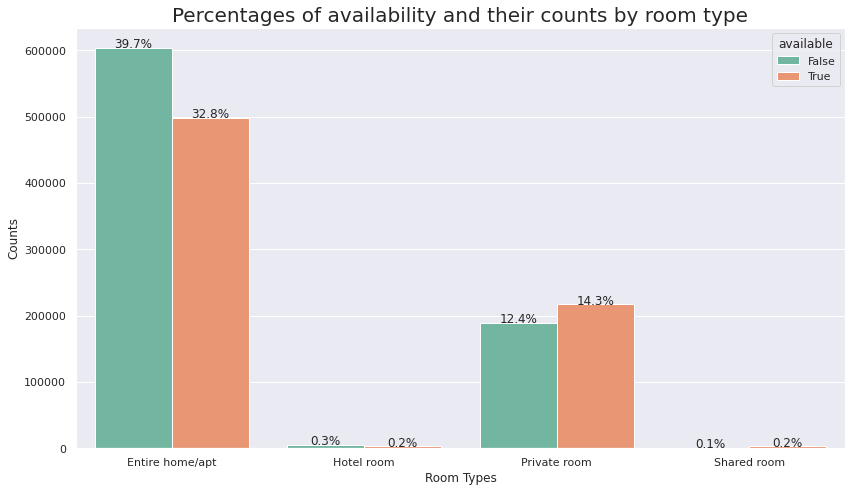

In [194]:
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True

percentage = available_roomtype['Percentage']
ax = sns.barplot(x="room_type", y='Count', hue="available", data=available_roomtype, palette='Set2')
patches = ax.patches
ax.set_title("Percentages of availability and their counts by room type" , size = 20)
ax.set_xlabel("Room Types" , size = 12)
ax.set_ylabel("Counts" , size = 12)

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(percentage[i]), (x,y), ha='center')
plt.show()

# <font color='#A533FF'>Module 4: Data Modelling</font>

### Question 3. How well can we predict the Airbnb price? What aspects correlate well to the price?

In [195]:
pd.set_option('display.max_columns', len(listings_copy.columns))
listings_copy.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,48154,https://www.airbnb.com/rooms/48154,20211218004345,2021-12-18,beautiful apartment wifi,<b>The space</b><br />Hello everybody and than...,NaN,https://a0.muscache.com/pictures/1109085/9c0d4...,219476,https://www.airbnb.com/users/show/219476,Toni,2010-09-01,"Valencia, Valencian Community, Spain",Un saludo a todos. Espero que os pongáis en co...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/219476/profil...,https://a0.muscache.com/im/users/219476/profil...,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,MORVEDRE,LA SAIDIA,39.48375,-0.37502,Entire rental unit,Entire home/apt,4,1 bath,2.0,2.0,"[""Host greets you"", ""Kitchen"", ""Shampoo"", ""Ded...",$98.00,3,25,3,3,25,25,3.0,25.0,t,17,47,77,352,2021-12-18,115,16,0,2010-10-12,2021-11-14,4.57,4.66,4.61,4.83,4.72,4.44,4.52,f,2,2,0,0,0.84
1,55692,https://www.airbnb.com/rooms/55692,20211218004345,2021-12-18,Delight in city center,A great place to stay and visit Valencia.<br /...,NaN,https://a0.muscache.com/pictures/329316/a5d6a7...,120649,https://www.airbnb.com/users/show/120649,Pilar,2010-05-08,"Valencia, Valencian Community, Spain","We are a couple from Spain, no kids, no pets, ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/120649/profil...,https://a0.muscache.com/im/users/120649/profil...,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,LA SEU,CIUTAT VELLA,39.47658,-0.37654,Entire rental unit,Entire home/apt,3,NaN,1.0,1.0,"[""Essentials"", ""Host greets you"", ""Elevator"", ...",$100.00,1,730,1,1,730,730,1.0,730.0,t,0,0,0,170,2021-12-18,1,0,0,2014-11-11,2014-11-11,5.00,5.00,5.00,5.00,5.00,5.00,5.00,f,1,1,0,0,0.01
2,95393,https://www.airbnb.com/rooms/95393,20211218004345,2021-12-18,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,"This is ""Edificio Palomar Apartments"", I will ...",It is just 10 min walking distance to the Cath...,https://a0.muscache.com/pictures/931683/64aebc...,508042,https://www.airbnb.com/users/show/508042,Carmen,2011-04-14,"Valencia, Valencian Community, Spain",Nice to meet you. I´m valencian and love my jo...,within a day,89%,36%,f,https://a0.muscache.com/im/pictures/user/ba968...,https://a0.muscache.com/im/pictures/user/ba968...,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Valencia, Valenciana, Spain",EL CARME,CIUTAT VELLA,39.47685,-0.38181,Entire rental unit,Entire home/apt,6,2 baths,3.0,6.0,"[""Crib"", ""Children\u2019s books and toys"", ""El...",$141.00,2,1125,2,2,1125,1125,2.0,1125.0,t,13,41,59,200,2021-12-18,103,5,0,2011-06-14,2021-11-14,4.76,4.73,4.89,4.85,4.75,4.75,4.67,f,6,6,0,0,0.80
3,100347,https://www.airbnb.com/rooms/100347,20211218004345,2021-12-18,3BDR full Home at Sorolla station and Metro Jesús,Te va a encantar mi espacio

In [196]:
listings_copy = listings_copy.drop(columns=['id', 'name', 'description', 'neighborhood_overview',
                                           'neighbourhood', 'minimum_minimum_nights', 'maximum_minimum_nights', 
                                            'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                                            'maximum_nights_avg_ntm', 'has_availability','availability_30', 'availability_60',
                                            'availability_90', 'availability_365', 'amenities', 'neighbourhood_cleansed'])

listings_copy = listings_copy[listings_copy.columns.drop(list(listings_copy.filter(regex='host')))]
listings_copy = listings_copy[listings_copy.columns.drop(list(listings_copy.filter(regex='url')))]
listings_copy = listings_copy[listings_copy.columns.drop(list(listings_copy.filter(regex='scrape')))]
listings_copy = listings_copy[listings_copy.columns.drop(list(listings_copy.filter(regex='review')))]

In [197]:
listings_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  5546 non-null   object 
 1   latitude                      5546 non-null   float64
 2   longitude                     5546 non-null   float64
 3   property_type                 5546 non-null   object 
 4   room_type                     5546 non-null   object 
 5   accommodates                  5546 non-null   int64  
 6   bathrooms_text                5542 non-null   object 
 7   bedrooms                      5252 non-null   float64
 8   beds                          5429 non-null   float64
 9   price                         5546 non-null   object 
 10  minimum_nights                5546 non-null   int64  
 11  maximum_nights                5546 non-null   int64  
 12  instant_bookable              5546 non-null   object 
dtypes: 

In [198]:
listings_copy.price

0        $98.00
1       $100.00
2       $141.00
3       $106.00
4       $263.00
         ...   
5541    $191.00
5542     $50.00
5543     $48.00
5544    $191.00
5545     $70.00
Name: price, Length: 5546, dtype: object

In [199]:
listings_copy['price'] = listings_copy['price'].replace('[\$,]', '', regex=True).astype(float)

<AxesSubplot:xlabel='price'>

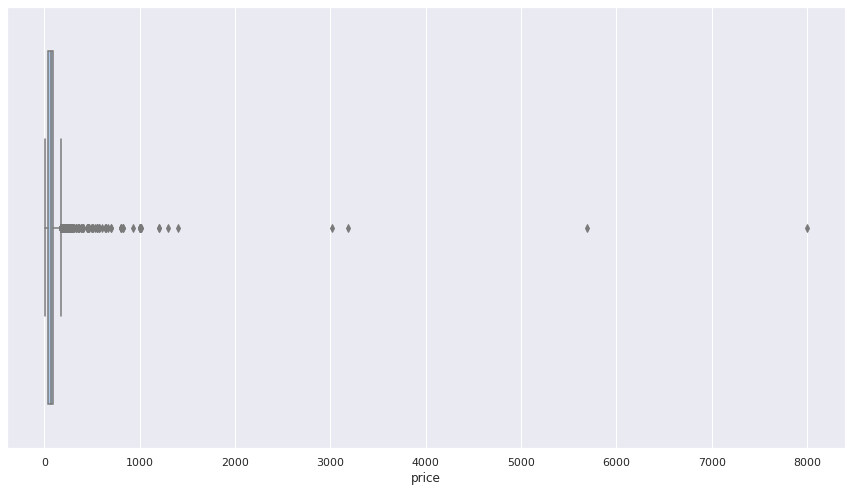

In [200]:
sns.boxplot(x=listings_copy["price"], palette="pastel")

We observe some outliers that it is needed to remove from the dataset.

In [201]:
listings_copy = listings_copy[listings_copy.price < 300]

<AxesSubplot:xlabel='price'>

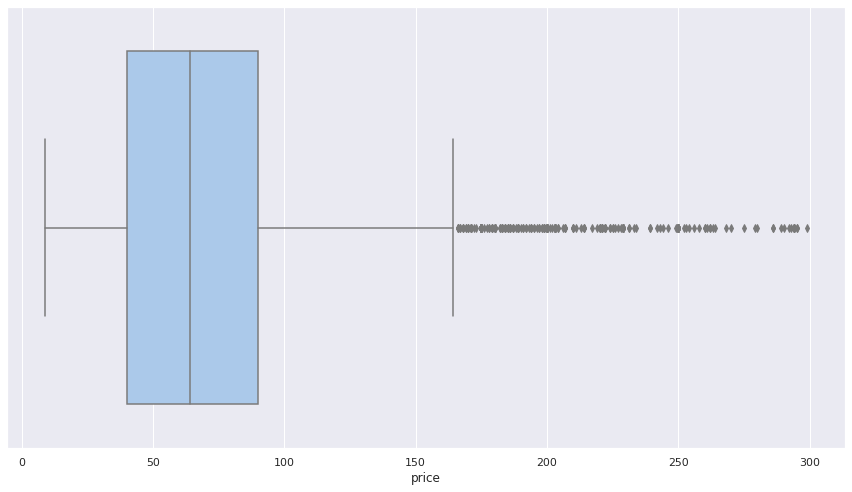

In [202]:
sns.boxplot(x=listings_copy["price"], palette="pastel")

In [203]:
listings_copy

,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable
0,LA SAIDIA,39.483750,-0.375020,Entire rental unit,Entire home/apt,4,1 bath,2.0,2.0,98.0,3,25,f
1,CIUTAT VELLA,39.476580,-0.376540,Entire rental unit,Entire home/apt,3,NaN,1.0,1.0,100.0,1,730,f
2,CIUTAT VELLA,39.476850,-0.381810,Entire rental unit,Entire home/apt,6,2 baths,3.0,6.0,141.0,2,1125,f
3,EXTRAMURS,39.459650,-0.384530,Entire rental unit,Entire home/apt,6,2 baths,3.0,3.0,106.0,3,66,f
4,POBLATS MARITIMS,39.481970,-0.324560,Entire villa,Entire home/apt,15,5.5 baths,5.0,20.0,263.0,1,1125,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5541,JESUS,39.457121,-0.383720,Entire cabin,Entire home/apt,2,1 bath,1.0,1.0,191.0,1,365,t
5542,LA SAIDIA,39.490313,-0.376200,Entire loft,Entire home/apt,3,1 bath,2.0,1.0,50.0,1,365,f
5543,POBLATS DEL NORD,39.561371,-0.292374,Entire condominium (condo),Entire home/apt,4,1 bath,1.0,2.0,48.0,1,1125,t
5544,L'EIXAMPLE,39.466888,-0.374173,Entire cabin,Entire home/apt,2,1 bath,1.0,1.0,191.0,1,365,t


In [204]:
listings_copy.property_type.value_counts()

Entire rental unit                     2926
Private room in rental unit            1219
Entire loft                             386
Entire condominium (condo)              135
Entire serviced apartment               120
Private room in residential home        102
Entire residential home                 102
Private room in condominium (condo)      71
Private room in bed and breakfast        58
Private room in casa particular          41
Room in boutique hotel                   35
Private room in serviced apartment       34
Entire townhouse                         32
Room in hotel                            29
Private room in hostel                   29
Private room in loft                     11
Private room in guest suite              10
Entire guest suite                        9
Entire vacation home                      8
Shared room in rental unit                8
Entire place                              8
Private room in townhouse                 8
Boat                            

In [205]:
property_types_dict = {
    'House': ['rental', 'condominium', 'home', 'Casa', 'townhouse', 'place', 'guesthouse', 'cottage', 'chalet'],
    'Apartment': ['loft', 'apartment'],
    'Hotel/Hostel': ['hotel', 'hostel']
}

In [206]:
newdict = {i: k for k, v in property_types_dict.items() for i in v}
listings_copy.property_type = listings_copy.property_type.str.findall('|'.join(newdict.keys())).str[0].map(newdict)

In [207]:
listings_copy.property_type = listings_copy.property_type.fillna('Other')
listings_copy.property_type.value_counts()

House           4642
Apartment        556
Other            151
Hotel/Hostel     105
Name: property_type, dtype: int64

In [208]:
listings_copy['bathrooms_text'] = listings_copy.loc[:,'bathrooms_text'].str.split(' ').str[0]
listings_copy['bathrooms_text'] = listings_copy.loc[:,'bathrooms_text'].replace({'Half-bath': 0.5, 'Shared': 0.5, 'Private': 1}, regex=True).astype(float)

listings_copy['bathrooms_text'].value_counts()
listings_copy.bathrooms_text.value_counts()

1.0    3561
2.0    1054
1.5     612
2.5      93
3.0      64
0.0      27
4.0      18
3.5       8
0.5       7
5.0       3
5.5       1
7.0       1
6.5       1
4.5       1
Name: bathrooms_text, dtype: int64

In [209]:
listings_copy.instant_bookable = listings_copy.instant_bookable.replace({"t": 1, "f": 0})

In [210]:
# Categorical variables that need to convert to dummy variables
listings_copy.select_dtypes(include = ['object'].copy())

,neighbourhood_group_cleansed,property_type,room_type
0,LA SAIDIA,House,Entire home/apt
1,CIUTAT VELLA,House,Entire home/apt
2,CIUTAT VELLA,House,Entire home/apt
3,EXTRAMURS,House,Entire home/apt
4,POBLATS MARITIMS,Other,Entire home/apt
...,...,...,...
5541,JESUS,Other,Entire home/apt
5542,LA SAIDIA,Apartment,Entire home/apt
5543,POBLATS DEL NORD,House,Entire home/apt
5544,L'EIXAMPLE,Other,Entire home/apt


In [262]:
# One-hot-encoding the variables
final_listings = pd.get_dummies(listings_copy)
final_listings.head()

,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable,neighbourhood_group_cleansed_ALGIROS,neighbourhood_group_cleansed_BENICALAP,neighbourhood_group_cleansed_BENIMACLET,neighbourhood_group_cleansed_CAMINS AL GRAU,neighbourhood_group_cleansed_CAMPANAR,neighbourhood_group_cleansed_CIUTAT VELLA,...,neighbourhood_group_cleansed_LA SAIDIA,neighbourhood_group_cleansed_PATRAIX,neighbourhood_group_cleansed_POBLATS DE L'OEST,neighbourhood_group_cleansed_POBLATS DEL NORD,neighbourhood_group_cleansed_POBLATS DEL SUD,neighbourhood_group_cleansed_POBLATS MARITIMS,neighbourhood_group_cleansed_QUATRE CARRERES,neighbourhood_group_cleansed_RASCANYA,property_type_Apartment,property_type_Hotel/Hostel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,39.48375,-0.37502,4,1.0,2.0,2.0,98.0,3,25,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,39.47658,-0.37654,3,NaN,1.0,1.0,100.0,1,730,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,39.47685,-0.38181,6,2.0,3.0,6.0,141.0,2,1125,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,39.45965,-0.38453,6,2.0,3.0,3.0,106.0,3,66,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,39.48197,-0.32456,15,5.5,5.0,20.0,263.0,1,1125,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0


In [212]:
# Checking columns with NaN values
print(final_listings.columns[(1 - final_listings.isnull().mean()) < 1])
# Check the % of NaN values
print((1 - final_listings[['bathrooms_text', 'bedrooms', 'beds']].isnull().mean()))

Index(['bathrooms_text', 'bedrooms', 'beds'], dtype='object')
bathrooms_text    0.999450
bedrooms          0.947561
beds              0.979281
dtype: float64


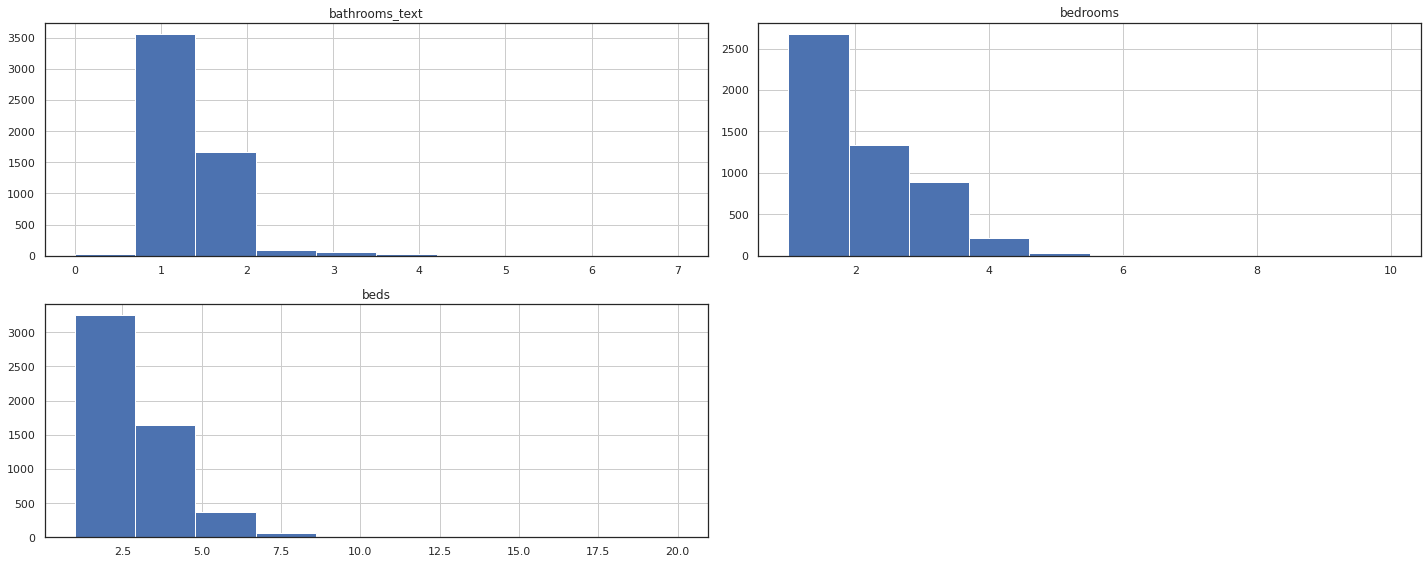

In [120]:
final_listings[['bathrooms_text', 'bedrooms', 'beds']].hist(figsize=(20,8));

**En vex de imputar los Nans con la media (hay categorias con muy pocos registros), imputo con la mediana**

In [263]:
for column in ['bathrooms_text', 'bedrooms', 'beds']:
    final_listings[column].fillna(final_listings[column].median(), inplace=True)

In [264]:
print(final_listings.columns[(1 - final_listings.isnull().mean()) < 1])

Index([], dtype='object')


In [265]:
final_listings.beds.dtypes

dtype('float64')

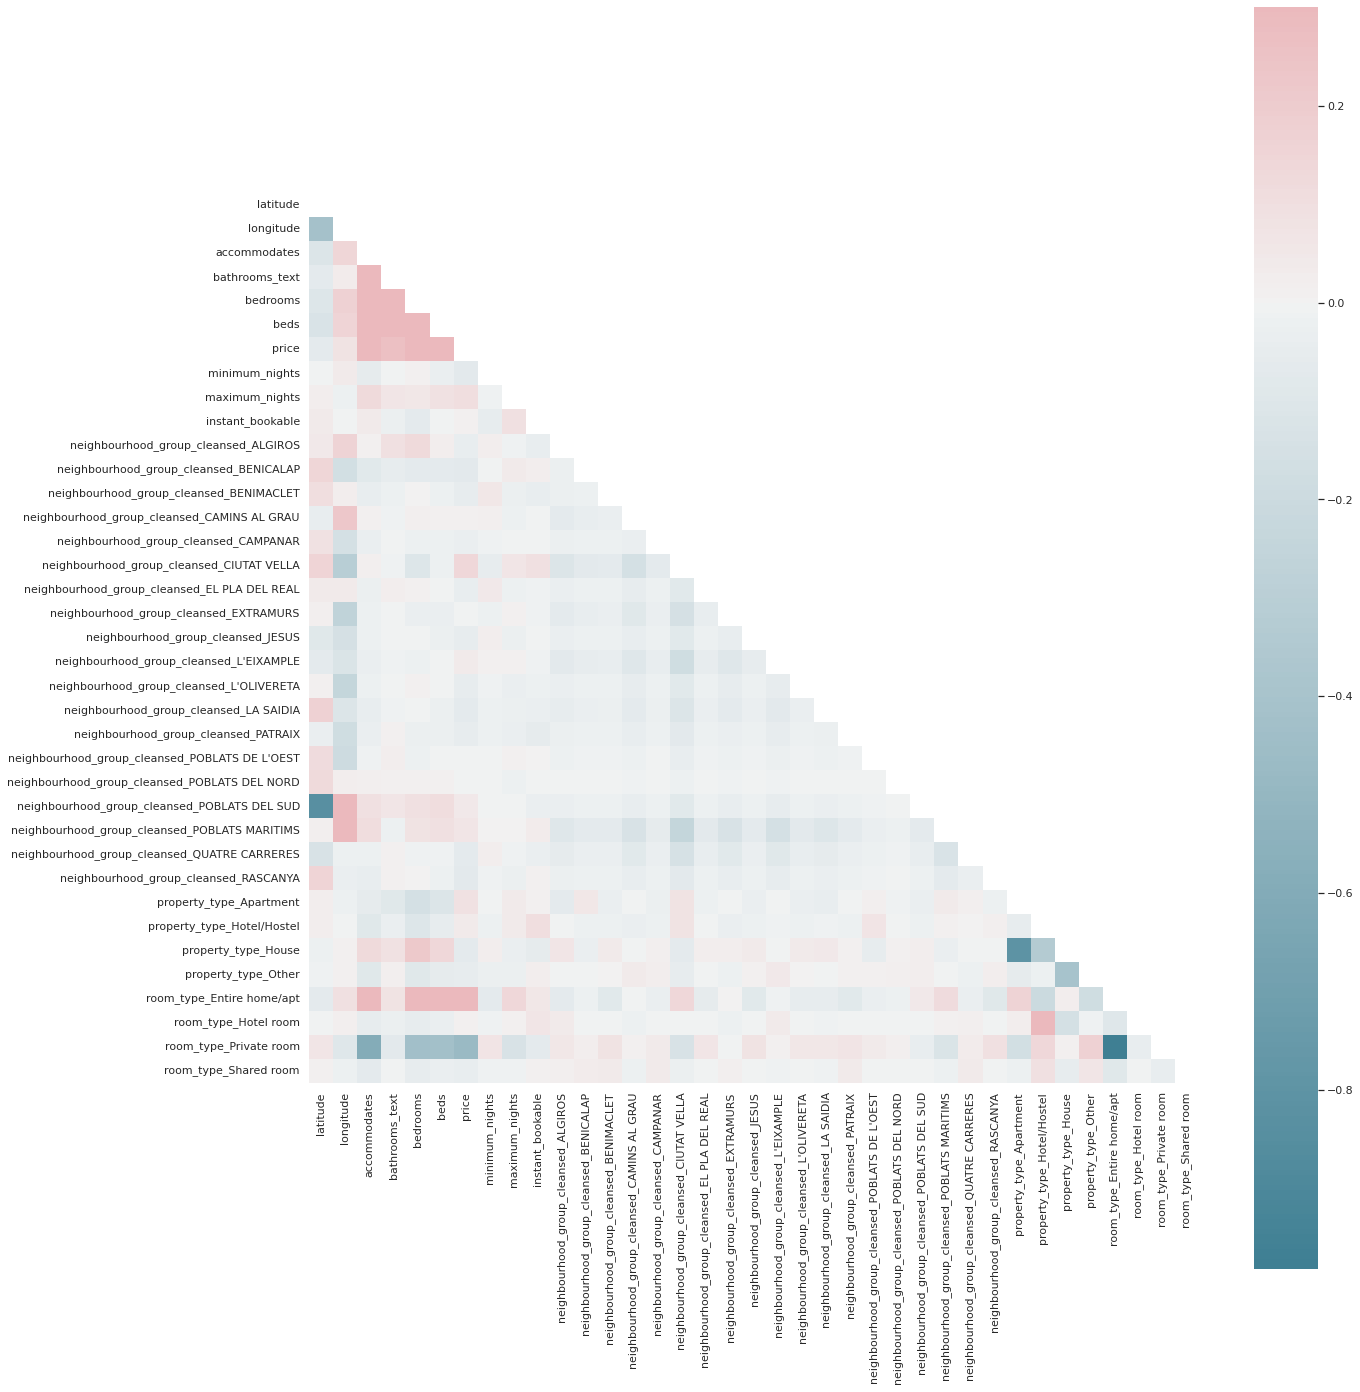

In [266]:
# Print a heatmap with the variable correlations
corr = final_listings.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap=cmap, center = 0)

In [267]:
final_listings = final_listings.drop(columns=['bedrooms',
                                              'beds',
                                              'bathrooms_text',
                                              'room_type_Private room'])

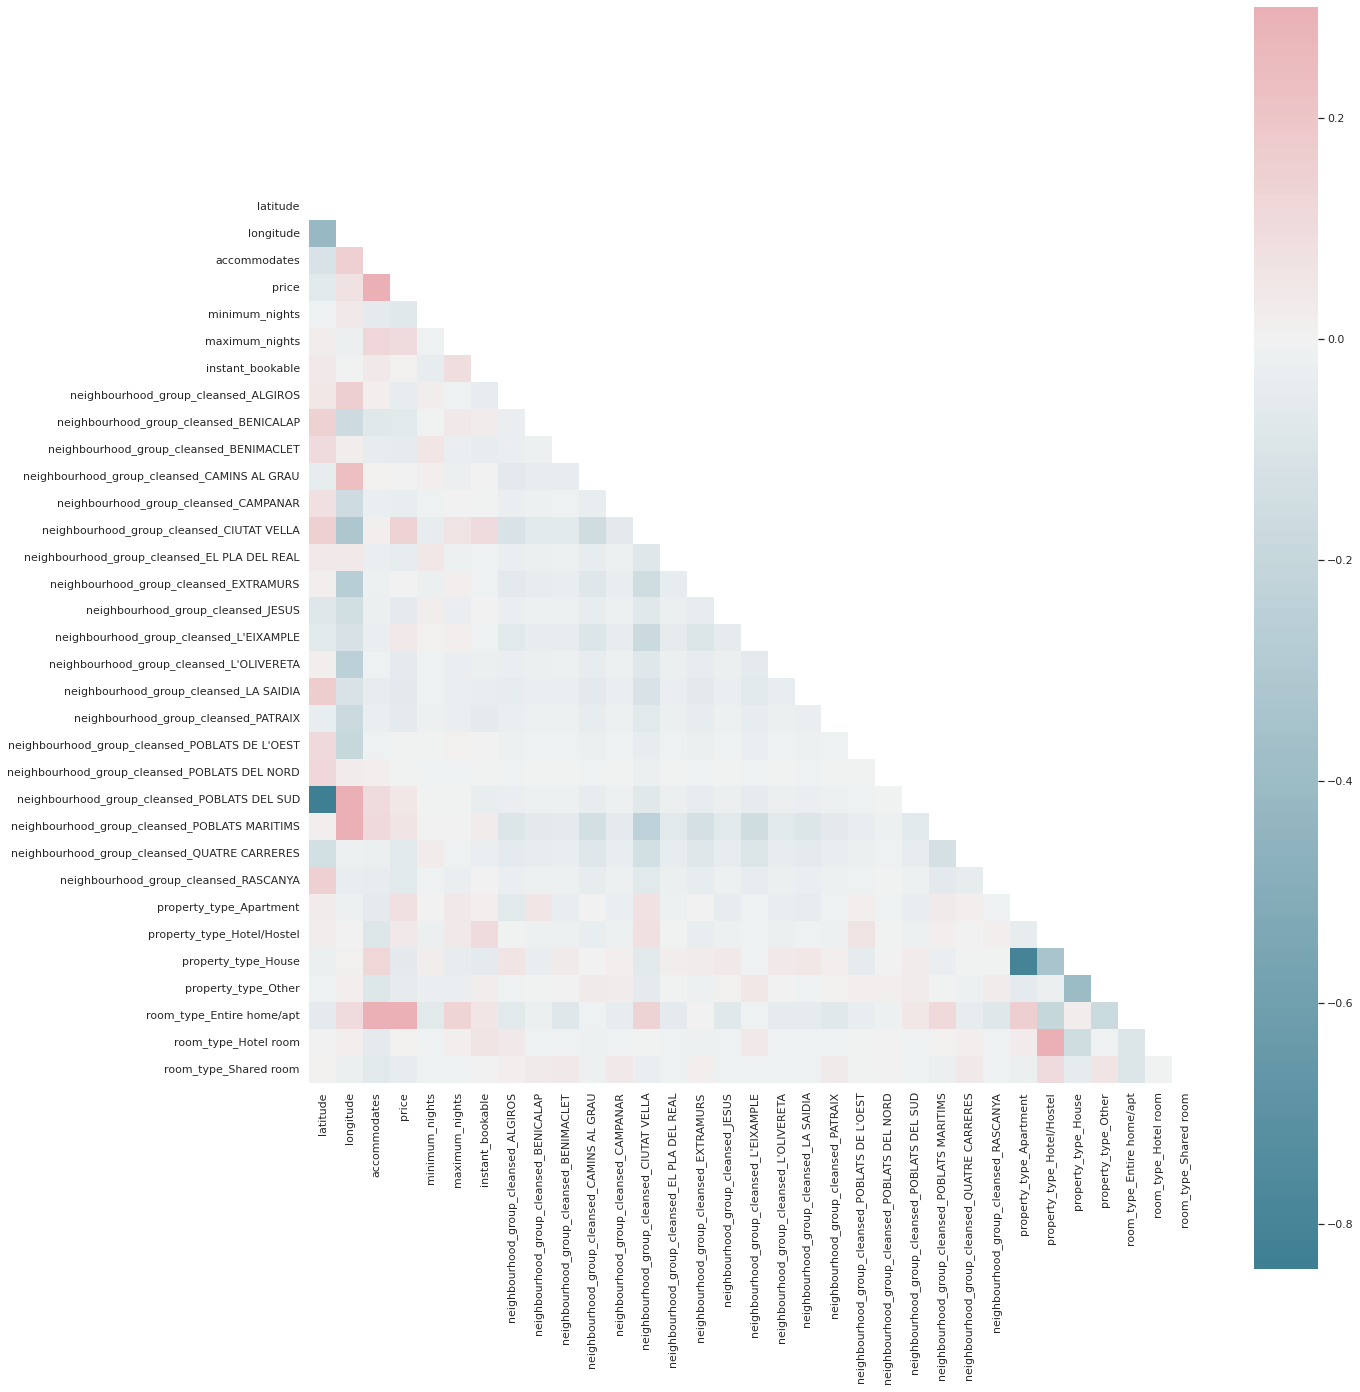

In [224]:
# Print a heatmap with the variable correlations
corr = final_listings.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap=cmap, center = 0)

In [268]:
corr_price = final_listings[final_listings.columns[0:]].corr()['price'][:]
corr_price[np.abs(corr_price) > 0.1].sort_values(ascending=False)

price                                        1.000000
accommodates                                 0.555769
room_type_Entire home/apt                    0.477573
neighbourhood_group_cleansed_CIUTAT VELLA    0.136847
maximum_nights                               0.102646
Name: price, dtype: float64

In [269]:
pd.set_option('display.max_columns', len(final_listings.columns))
final_listings.head()

,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,instant_bookable,neighbourhood_group_cleansed_ALGIROS,neighbourhood_group_cleansed_BENICALAP,neighbourhood_group_cleansed_BENIMACLET,neighbourhood_group_cleansed_CAMINS AL GRAU,neighbourhood_group_cleansed_CAMPANAR,neighbourhood_group_cleansed_CIUTAT VELLA,neighbourhood_group_cleansed_EL PLA DEL REAL,neighbourhood_group_cleansed_EXTRAMURS,neighbourhood_group_cleansed_JESUS,neighbourhood_group_cleansed_L'EIXAMPLE,neighbourhood_group_cleansed_L'OLIVERETA,neighbourhood_group_cleansed_LA SAIDIA,neighbourhood_group_cleansed_PATRAIX,neighbourhood_group_cleansed_POBLATS DE L'OEST,neighbourhood_group_cleansed_POBLATS DEL NORD,neighbourhood_group_cleansed_POBLATS DEL SUD,neighbourhood_group_cleansed_POBLATS MARITIMS,neighbourhood_group_cleansed_QUATRE CARRERES,neighbourhood_group_cleansed_RASCANYA,property_type_Apartment,property_type_Hotel/Hostel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Shared room
0,39.48375,-0.37502,4,98.0,3,25,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,39.47658,-0.37654,3,100.0,1,730,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,39.47685,-0.38181,6,141.0,2,1125,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,39.45965,-0.38453,6,106.0,3,66,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,39.48197,-0.32456,15,263.0,1,1125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0


In [270]:
from sklearn import preprocessing

d = preprocessing.normalize(final_listings.iloc[:, :6])
norm_df = pd.DataFrame(d, columns=final_listings.iloc[:, :6].columns)
norm_df = pd.concat([norm_df, final_listings.iloc[:, 6:]], axis=1)
norm_df.head()

,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,instant_bookable,neighbourhood_group_cleansed_ALGIROS,neighbourhood_group_cleansed_BENICALAP,neighbourhood_group_cleansed_BENIMACLET,neighbourhood_group_cleansed_CAMINS AL GRAU,neighbourhood_group_cleansed_CAMPANAR,neighbourhood_group_cleansed_CIUTAT VELLA,neighbourhood_group_cleansed_EL PLA DEL REAL,neighbourhood_group_cleansed_EXTRAMURS,neighbourhood_group_cleansed_JESUS,neighbourhood_group_cleansed_L'EIXAMPLE,neighbourhood_group_cleansed_L'OLIVERETA,neighbourhood_group_cleansed_LA SAIDIA,neighbourhood_group_cleansed_PATRAIX,neighbourhood_group_cleansed_POBLATS DE L'OEST,neighbourhood_group_cleansed_POBLATS DEL NORD,neighbourhood_group_cleansed_POBLATS DEL SUD,neighbourhood_group_cleansed_POBLATS MARITIMS,neighbourhood_group_cleansed_QUATRE CARRERES,neighbourhood_group_cleansed_RASCANYA,property_type_Apartment,property_type_Hotel/Hostel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Shared room
0,0.363276,-0.003450,0.036803,0.901662,0.027602,0.230016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.053500,-0.000510,0.004066,0.135523,0.001355,0.989319,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.034797,-0.000337,0.005289,0.124283,0.001763,0.991621,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.300928,-0.002933,0.045757,0.808378,0.022879,0.503330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.034151,-0.000281,0.012975,0.227488,0.000865,0.973095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [279]:
norm_df = norm_df.dropna()

In [280]:
norm_df.isna().sum()

latitude                                          0
longitude                                         0
accommodates                                      0
price                                             0
minimum_nights                                    0
maximum_nights                                    0
instant_bookable                                  0
neighbourhood_group_cleansed_ALGIROS              0
neighbourhood_group_cleansed_BENICALAP            0
neighbourhood_group_cleansed_BENIMACLET           0
neighbourhood_group_cleansed_CAMINS AL GRAU       0
neighbourhood_group_cleansed_CAMPANAR             0
neighbourhood_group_cleansed_CIUTAT VELLA         0
neighbourhood_group_cleansed_EL PLA DEL REAL      0
neighbourhood_group_cleansed_EXTRAMURS            0
neighbourhood_group_cleansed_JESUS                0
neighbourhood_group_cleansed_L'EIXAMPLE           0
neighbourhood_group_cleansed_L'OLIVERETA          0
neighbourhood_group_cleansed_LA SAIDIA            0
neighbourhoo

## Linear Regression

In [290]:
X = norm_df.drop('price', axis = 1)
y = norm_df['price']

# Split into train (70%) and test(30%) with a setseed of 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

In [282]:
# Instantiate a linear model
lm_model = LinearRegression(normalize=True) 

# Fitting the model to our data
lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [283]:
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))

The r-squared score for the model using only quantitative variables was 0.882618281992993 on 1609 values.


In [299]:
root_mse = (mean_squared_error(y_test, y_test_preds))**(1/2)
root_mse

0.09587399791440811

## Random Forest Regressor

In [291]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2090)

# Train the model on training data
rf.fit(train_X, train_y);

In [292]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [293]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.72 %.


# <font color='#A533FF'>Module 5: Result Evaluation</font>

# <font color='#A533FF'>Module 6: Deployment </font>

This section is available on the following sites:

[...]